<a href="https://colab.research.google.com/github/Depdx/INF8250AE--Reinforcement-Learning/blob/main/INF8250AE_Assignment_1_2083544.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Assignment 1

## Instructions:
* This is an individual assignment. You are not allowed to discuss the problems with other students.
* Part of this assignment will be autograded by gradescope. You can use it as immediate feedback to improve your answers. You can resubmit as many times as you want.
* All your solution, code, analysis, graphs, explanations should be done in this same notebook.
* Please make sure to execute all the cells before you submit the notebook to the gradescope. You will not get points for the plots if they are not generated already.
* If you have questions regarding the assignment, you can ask for clarifications in Piazza. You should use the corresponding tag for this assignment.


**When Submitting to GradeScope**: Be sure to
1) Submit a `.ipynb` notebook to the `Assignment 1 - Code` section on Gradescope.
2) Submit a `pdf` version of the notebook to the `Assignment 1 - Report` entry and tag the answers.

**Note**: You can choose to submit responses in either English or French.

Before starting the assignment, make sure that you have downloaded all the tests related for the assignment and put them in the appropriate locations. If you run the next cell, we will set this all up automatically for you in a dataset called public, which will contain both the data and tests you use.

This assignment has only one question. In this question, you will learn:

1. To understand how to formalize a dose finding study as a multi-arm bandit problem.
2. To implement **$\epsilon$-greedy**, **UCB**, **Boltzmann**, and **Gradient bandit** algorithms.
3. Understand the role of different hyper-parameters.


In [1]:
!pip install -q otter-grader
!git clone https://github.com/chandar-lab/INF8250ae-assignments-2023.git public

fatal: destination path 'public' already exists and is not an empty directory.


In [2]:
import otter
grader = otter.Notebook(colab=True, tests_dir='./public/a1/tests')

In [3]:
import numpy as np
from random import choice, randint
from scipy.stats import bernoulli
from typing import Sequence, Tuple
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(8953)
import warnings
warnings.filterwarnings('ignore')

## Q1: Dose Finding Study (90 points)

In the context of clinical trials, Phase I trials are the first stage of testing in human subjects. Their goal is to evaluate the safety (and feasibility) of the treatment and identify its side effects. The aim of a phase I dose-finding study is to determine the most appropriate dose level that should be used in further phases of the clinical trials. Traditionally, the focus is on determining the highest dose with acceptable toxicity called the Maximum Tolerated Dose (MTD).

A dose-finding study involves a number K of dose levels that have been chosen by physicians based on preliminary experiments (K is usually a number between 3 and 10). Denoting by $p_k$ the (unknown) toxicity probability of dose $k$, the Maximum Tolerated Dose (MTD) is defined as the dose with a toxicity probability closest to a target:

\begin{align}
k^* \in \underset{k\in\{1,\dots,K\}}{\mathrm{argmin}}|\theta - p_k|
\end{align}

where $\theta$ is the pre-specified targeted toxicity probability (typically between 0.2 and 0.35).
A MTD identification algorithm proceeds sequentially: at round $t$ a dose $D_t \in \{1, \dots , K\}$ is selected and administered to a patient for whom a toxicity response is observed. A binary outcome $X_t$ is revealed where $X_t = 1$ indicates that a harmful side-effect occurred and $X_t = 0$ indicates than no harmful side-effect occurred. We assume that $X_t$ is drawn from a Bernoulli distribution with mean $p_{D_t}$ and is independent from previous observations.

**Hint**: In this example, the reward definition is a bit different from the usual case. We would like to take the arm with minimum $|\theta - \hat{p}_k|$ where $\hat{p}_k$ is the estimated toxicity probability.

### Q1.a: Define your Bandit class (5 points):

Most of the class has been written. Complete the pull method in such a way that:

**1.** Update both `num_dose_selected` and `num_toxic` arrays,

**2.** Compute and return the reward $-|\theta - \hat{p}_k|$ where $\hat{p}_k$ is the estimated toxicity probability of arm $k$.

In [4]:
class Bandit(object):

  def __init__(self,
               n_arm: int = 2,
               n_pulls: int = 2000,
               actual_toxicity_prob: list = [0.4, 0.6],
               theta: float = 0.3,
               ):
    self.n_arm = n_arm
    self.n_pulls = n_pulls
    self.actual_toxicity_prob = actual_toxicity_prob
    self.theta = theta
    # ----------------------------------------------
    self.a_star = np.argmax([-abs(theta - p) for p in actual_toxicity_prob])
    self.q_a_star = max([-abs(theta - p) for p in actual_toxicity_prob])
    # ----------------------------------------------
    self.init_bandit()

  def init_bandit(self):
    """
        Initialize the bandit
    """
    self.num_dose_selected = np.array([0]*self.n_arm) # number of times a dose is selected
    self.num_toxic = np.array([0]*self.n_arm) # number of times a does found to be toxic

  def pull(self, a_idx: int):
    """
    .inputs:
      a_idx: Index of action.
    .outputs:
      rew: reward value.
    """
    assert a_idx < self.n_arm, "invalid action index"
    # ----------------------------------------------
    self.num_dose_selected[a_idx] = self.num_dose_selected[a_idx] + 1
    is_toxic = bernoulli.rvs(self.actual_toxicity_prob[a_idx])
    self.num_toxic[a_idx] = self.num_toxic[a_idx] + is_toxic
    p_hat = self.num_toxic[a_idx]/self.num_dose_selected[a_idx]
    rew = -abs(self.theta - p_hat)
    # ----------------------------------------------
    return rew

In [5]:
grader.check("q1a")

q1.a results: All test cases passed!

### Dose finding study with three doses

Let's define a dose finding study with three doses ($K = 3$) where you need to choose from with `actual_toxicity_prob=[0.1, 0.35, 0.8]` and targeted toxicity probability is $\theta = 0.3$.

In [6]:
#@title Problem definition
bandit = Bandit(n_arm=3, n_pulls=2000, actual_toxicity_prob=[0.1, 0.35, 0.8], theta=0.3)

### Q1.b: $\epsilon$-greedy for k-armed bandit and Optimistic initial values (25 points)

#### Q1.b1: $\epsilon$-greedy algorithm implementation (5 points)

Implement the $\epsilon$-greedy method.

In [7]:
def eps_greedy(
    bandit: Bandit,
    eps: float,
    init_q: float = .0
    ) -> Tuple[list, list, list]:
  """
  .inputs:
    bandit: A bandit problem, instantiated from the above class.
    eps: The epsilon value.
    init_q: Initial estimation of each arm's value.
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average of rewards up to step t, where t goes from 0 to n_pulls. For example: If
    we define `ret_T` = \sum^T_{t=0}{r_t}, `avg_ret_record` = ret_T / (1+T).
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
    opt_action_perc_record: Percentage of optimal arm selected.
  """
  # initialize q values
  q = np.array([init_q]*bandit.n_arm, dtype=float)

  ret = .0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []
  opt_action_perc_record = []

  for t in range(bandit.n_pulls):
    # ----------------------------------------------
    explore = np.random.binomial(1, eps)
    a:int = None
    if explore:
      a = randint(0, len(q)-1)
    else:
      a = np.argmax(q)

    rew = bandit.pull(a)
    q[a] = q[a] + (rew - q[a]) / (bandit.num_dose_selected[a])
    rew_record.append(rew)
    ret += rew
    avg_ret_record.append(ret / (t+1))

    tot_reg_record.append((t+1) * bandit.q_a_star - ret)

    opt_action_perc = np.sum(bandit.num_dose_selected[bandit.a_star])/np.sum(bandit.num_dose_selected)
    opt_action_perc_record.append(opt_action_perc)
    # ----------------------------------------------

  return rew_record, avg_ret_record, tot_reg_record, opt_action_perc_record


In [8]:
grader.check("q1b1")

q1.b1 results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Q1.b2: Plotting the results (5 points)

Use the driver code provided to plot: (1) The average return, (2) The reward, (3) the total regret, and (4) the percentage of optimal action across the $N$=20 runs as a function of the number of pulls (2000 pulls for each run) for all three $\epsilon$ values of 0.5, 0.1, and 0.

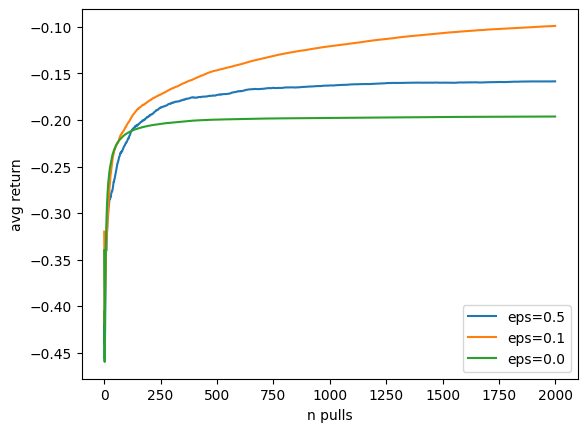

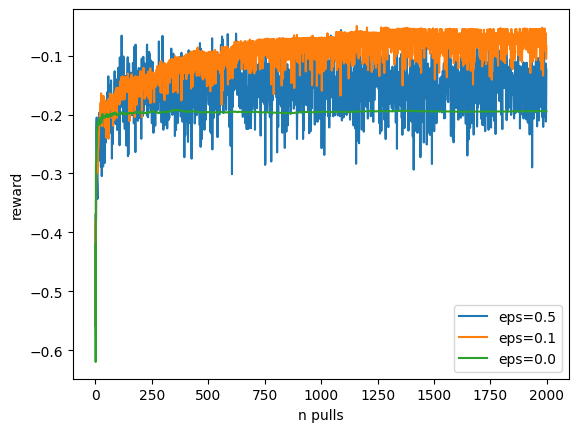

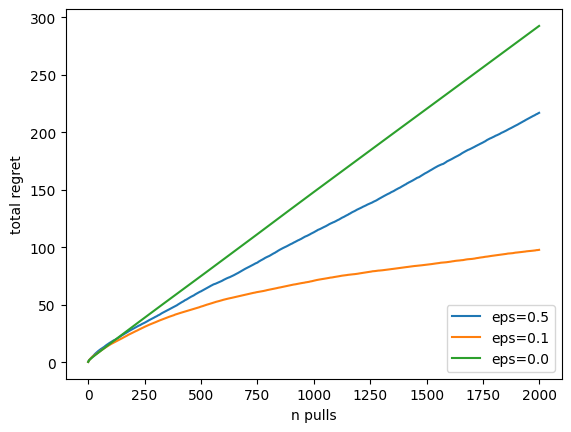

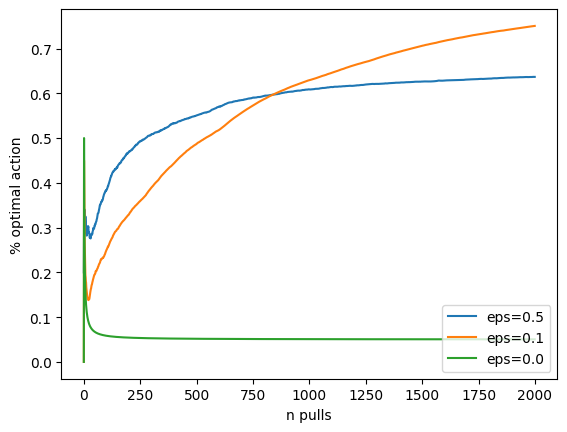

In [9]:
import time
plt.figure(0)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(1)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(2)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(3)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8

for eps in [0.5, 0.1, .0]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)
  start_time = time.time()
  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = eps_greedy(bandit, eps)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)

  end_time = time.time()
  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N

  plt.figure(0)
  plt.plot(avg_ret_rec, label="eps={}".format(eps))
  plt.legend(loc="lower right")

  plt.figure(1)
  plt.plot(rew_rec[1:], label="eps={}".format(eps))
  plt.legend(loc="lower right")

  plt.figure(2)
  plt.plot(tot_reg_rec, label="eps={}".format(eps))
  plt.legend(loc="lower right")

  plt.figure(3)
  plt.plot(opt_act_rec, label="eps={}".format(eps))
  plt.legend(loc="lower right")


  if tot_reg_rec[-1] < tot_reg_rec_best:
        ep_greedy_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Q1.b3: Analysis (5 points)


Explain the results from the perspective of exploration and how different $\epsilon$ values affect the results.


With probability $\epsilon$, the agent chooses to explore by taking a random action from its action space. This encourages the agent to try out new actions to discover potentially better strategies.

With probability 1-$\epsilon$, the agent chooses to exploit by selecting the action that is currently estimated to be the best according to its learned value function. This exploits the agent's current knowledge to maximize its expected rewards.

The choice of the epsilon value $\epsilon$ plays a critical role in how the agent explores its environment and, consequently, affects the learning process. Let's examine how different values of ε affect the results:

When $\epsilon$ is 0.5, the agent is doing a fifty fifty on exploration over exploitation. Thus, it frequently takes random actions, which may help it discover new and potentially better strategies. However, it leads to inefficient and erratic behavior, especially when the agent already has a good estimate of the optimal policy. The agent may waste time exploring suboptimal actions when it should be exploiting its current knowledge. It performs less good then the $\epsilon$ = 0.1.


When $\epsilon$ is set to 0, the agent strictly follows the policy that it currently believes to be the best. This means it exploits its current knowledge without exploring any further. While $\epsilon$=0.1 ensures that the agent consistently chooses actions it believes to be optimal, it leads to suboptimal results in the long run if the agent's initial estimates are inaccurate like our case.

When, $\epsilon$ is set to 0.1, striking a balance between exploration and exploitation. This allows the agent to learn while also making decisions based on its current best estimate. This is the best choice for our case.


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Q1.b4: Optimistic Initial Values (5 points)
We want to run the optimistic initial value method on the same problem described above for the initial q values of -1 and +1 for all arms. Compare its performance, measured by the average reward across $N$=20 runs as a function of the number of pulls, with the non-optimistic setting with initial q values of 0 for all arms. For both optimistic and non-optimistic settings, $\epsilon$=0.

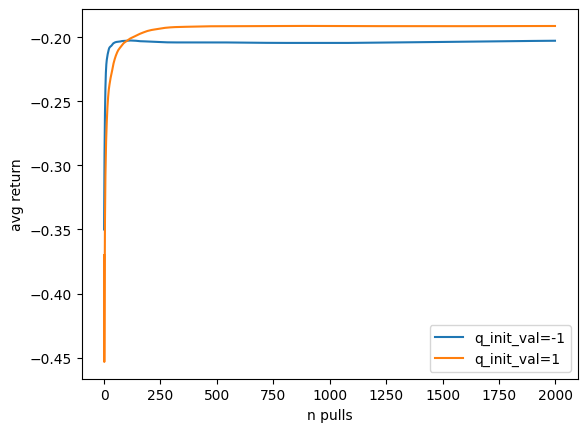

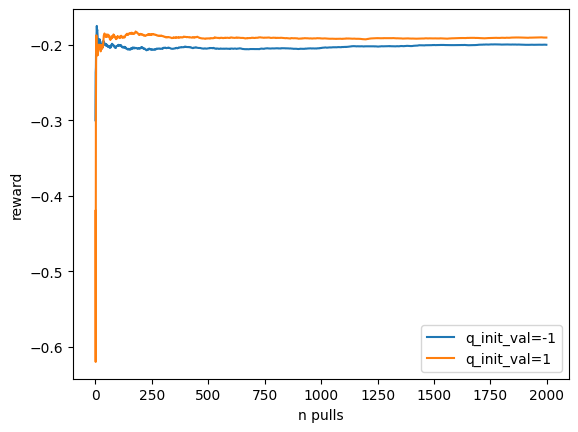

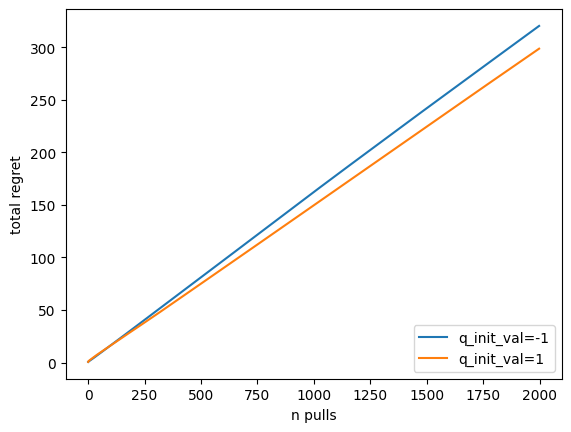

In [10]:
plt.figure(4)
plt.xlabel("n pulls")
plt.ylabel("avg return")

plt.figure(5)
plt.xlabel("n pulls")
plt.ylabel("reward")

plt.figure(6)
plt.xlabel("n pulls")
plt.ylabel("total regret")

N = 20
for init_q in [-1, 1]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = eps_greedy(bandit, eps=0.0, init_q=init_q)

    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)

  avg_ret_rec /= N
  rew_rec /= N
  tot_reg_rec /= N
  plt.figure(4)
  plt.plot(avg_ret_rec[1:], label="q_init_val={}".format(init_q))
  plt.legend(loc="lower right")

  plt.figure(5)
  plt.plot(rew_rec[1:], label="q_init_val={}".format(init_q))
  plt.legend(loc="lower right")

  plt.figure(6)
  plt.plot(tot_reg_rec[1:], label="q_init_val={}".format(init_q))
  plt.legend(loc="lower right")

#### Q1.b5: Analysis (5 points)

Explain how initial q values affect the exploration and the performance.

1. **Initial Q-values set to Q=1:**
   - When all initial Q-values are set to a high positive value, the agent starts with an optimistic view of all actions. This means it initially believes that every action can lead to high rewards.
   - Impact on Exploration:
     - High initial Q-values encourage exploration, as the agent is inclined to try various actions in different states in pursuit of the assumed high rewards.
     - This optimism promotes active exploration of the environment, as the agent wants to verify if its optimistic assumptions are correct.
   - Impact on Performance:
     - Initially, the agent may perform better than if it had pessimistic initial Q-values, as it is more willing to explore and try different actions.
     - However, if the environment does not align with the initial optimistic estimates like in this case, the agent may experience initial episodes of poor performance as it tries suboptimal actions.

2. **Initial Q-values set to Q=-1:**
   - When all initial Q-values are set to a low negative value, the agent starts with a pessimistic view of all actions. It assumes that taking any action will result in low rewards.
   - Impact on Exploration:
     - Low initial Q-values discourage exploration, as the agent is less motivated to try actions that it believes will yield poor outcomes.
     - The agent may stick to a limited set of actions that it deems less risky but may miss out on potentially better strategies.
   - Impact on Performance:
     - Initially, the agent may be risk-averse and less likely to try new actions. This can result in slower learning and potentially suboptimal performance which is the case observed.

<!-- END QUESTION -->

### Q1.c: Upper-Confidence-Bound action selection (15 points)

#### Q1.c1: UCB algorithm implementation (5 points)
Implement the UCB algorithm on the same MAB problem as above.

In [11]:
def ucb(
    bandit: Bandit,
    c: float,
    init_q: float = .0
    ) -> Tuple[list, list, list]:
  """
  .inputs:
    bandit: A bandit problem, instantiated from the above class.
    c: The additional term coefficient.
    init_q: Initial estimation of each arm's value.
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average summation of rewards up to step t, where t goes from 0 to n_pulls. For example: If
    we define `ret_T` = \sum^T_{t=0}{r_t}, `avg_ret_record` = ret_T / (1+T).
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
    opt_action_perc_record: Percentage of optimal arm selected.
  """
  # init q values (the estimates)
  q = np.array([init_q]*bandit.n_arm, dtype=float)

  ret = .0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []
  opt_action_perc_record = []

  for t in range(bandit.n_pulls):
    # Assuming to take the first arm always when there is no exploration
    # ----------------------------------------------
    ucb = []
    for a in range(bandit.n_arm):
        if bandit.num_dose_selected[a] == 0:
            ucb.append(float('inf'))
        else:
            ucb.append(q[a] + c * np.sqrt(np.log(t+1) / (bandit.num_dose_selected[a])))

    a = np.argmax(ucb)

    rew = bandit.pull(a)
    q[a] = q[a] + (rew - q[a]) / (bandit.num_dose_selected[a])
    rew_record.append(rew)
    ret += rew
    avg_ret_record.append(ret / (t+1))

    tot_reg_record.append((t+1) * bandit.q_a_star - ret)

    opt_action_perc = np.sum(bandit.num_dose_selected[bandit.a_star])/np.sum(bandit.num_dose_selected)
    opt_action_perc_record.append(opt_action_perc)
    # ----------------------------------------------

  return rew_record, avg_ret_record, tot_reg_record, opt_action_perc_record

In [12]:
grader.check("q1c1")

q1.c1 results: All test cases passed!

#### Q1.c2: Plotting the results (5 points)

Use the driver code provided to plot: (1) The average return, (2) The reward, (3) the total regret, and (4) the percentage of optimal action across the $N$=20 runs as a function of the number of pulls (2000 pulls for each run) for three values of $c$=0, 0.5, and 2.0.

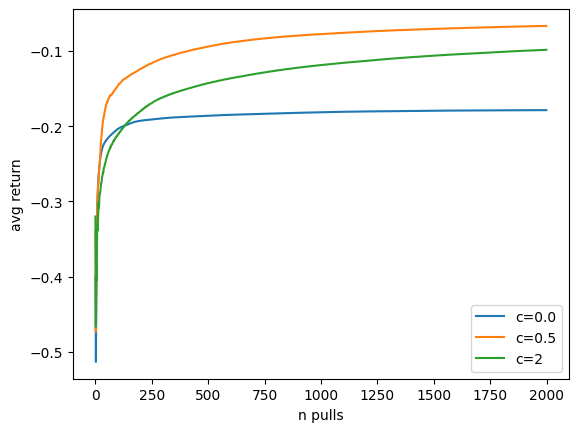

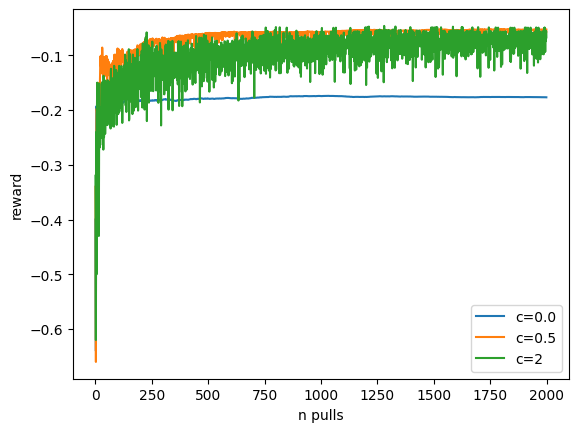

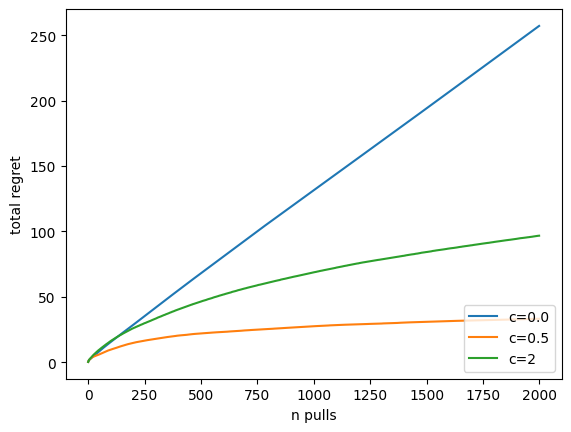

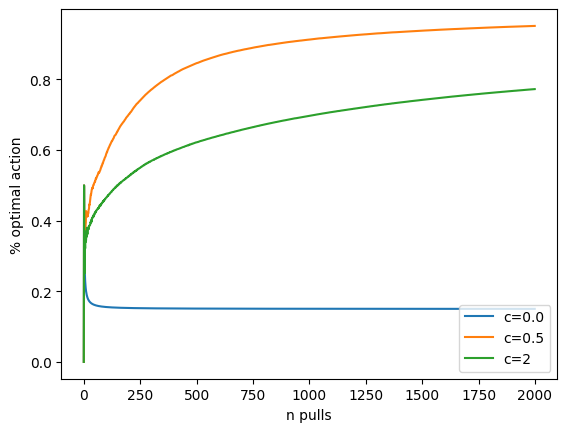

In [13]:
plt.figure(7)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(8)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(9)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(10)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8
for c in [.0, 0.5, 2]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)

  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = ucb(bandit, c)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)

  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N

  plt.figure(7)
  plt.plot(avg_ret_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  plt.figure(8)
  plt.plot(rew_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  plt.figure(9)
  plt.plot(tot_reg_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  plt.figure(10)
  plt.plot(opt_act_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        ucb_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Q1.c3: Analysis (5 points)


 Explain the results from the perspective of exploration and how different $c$ values affect the results.

1. **c = 0 (Low Exploration):**
   - When "c" is set to 0, the UCB algorithm essentially becomes a purely exploitation-driven strategy.
   - As a result, it will not explore any arms that it hasn't already deemed as the best, which leads to suboptimal performance, especially if initial estimates are inaccurate or if there are arms with higher rewards that the algorithm has not yet explored.
   - It explains the suboptimal performance of the algorithm in our case. It is the worst choice for our case.

2. **c = 0.5 (Balanced Exploration and Exploitation):**
   - With "c" set to 0.5, the UCB algorithm achieves a balance between exploration and exploitation.
   - The algorithm assigns exploration bonuses to actions, but they are not overly aggressive. It is willing to explore arms that have some uncertainty in their estimated rewards but still tends to exploit the arms it believes to be better.
   - It is the one that performed the best in our case.

3. **c = 2 (High Exploration):**
   - When "c" is set to 2, the UCB algorithm prioritizes exploration significantly.
   - The exploration bonuses assigned to actions are substantial, encouraging the algorithm to explore arms even if they have been sampled less frequently or have higher uncertainty in their reward estimates.
   - It explains the suboptimal performance of the algorithm in our case.


### Q1.d: Boltzmann algorithm (20 points)

#### Q1.d1: Boltzmann policy implementation (5 points)

Implement a Boltzmann policy that gets an array and temprature value ($\tau$) and returns an index sampled from the Boltzmann policy.

In [14]:
def boltzmann_policy(x, tau):
    """ Returns softmax probabilities with temperature tau
        Input:  x -- 1-dimensional array
        Output: idx -- chosen index
    """
    # ----------------------------------------------
    x = np.array(x)
    exp_x = np.exp(x/tau)
    p = exp_x / np.sum(exp_x)
    idx = np.random.choice(len(x), p=p)
    # ----------------------------------------------
    return idx

In [15]:
grader.check("q1d1")

q1.d1 results: All test cases passed!

#### Q1.d2: Boltzmann algorithm implementation (5 points)

Evaluate the Boltzmann algorithm on the same MAB problem as above, for three values of the parameters $\tau$: $0.01$, $0.1$, and $1$. Use the driver code provided to plot their performances across $N$=20 runs as a function of the number of pulls.

**Note:** You can use action-value estimates for the Boltzmann distribution.

In [16]:
def boltzmann(
    bandit: Bandit,
    tau: float = 0.1,
    init_q: float = .0
    ) -> Tuple[list, list, list]:
  """
  .inputs:
    bandit: A bandit problem, instantiated from the above class.
    tau: The additional term coefficient.
    init_q: Initial estimation of each arm's value.
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average summation of rewards up to step t, where t goes from 0 to n_pulls. For example: If
    we define `ret_T` = \sum^T_{t=0}{r_t}, `avg_ret_record` = ret_T / (1+T).
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
    opt_action_perc_record: Percentage of optimal arm selected.
  """
  # init q values (the estimates)
  q = np.array([init_q]*bandit.n_arm, dtype=float)

  ret = .0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []
  opt_action_perc_record = []

  for t in range(bandit.n_pulls):
    # ----------------------------------------------
    a = boltzmann_policy(q, tau)

    rew = bandit.pull(a)
    q[a] = q[a] + (rew - q[a]) / (bandit.num_dose_selected[a])
    rew_record.append(rew)
    ret += rew
    avg_ret_record.append(ret / (t+1))

    tot_reg_record.append((t+1) * bandit.q_a_star - ret)

    opt_action_perc = np.sum(bandit.num_dose_selected[bandit.a_star])/np.sum(bandit.num_dose_selected)
    opt_action_perc_record.append(opt_action_perc)
    # ----------------------------------------------

  return rew_record, avg_ret_record, tot_reg_record, opt_action_perc_record

In [17]:
grader.check("q1d2")

q1.d2 results: All test cases passed!

#### Q1.d3: Plotting the results (5 points)

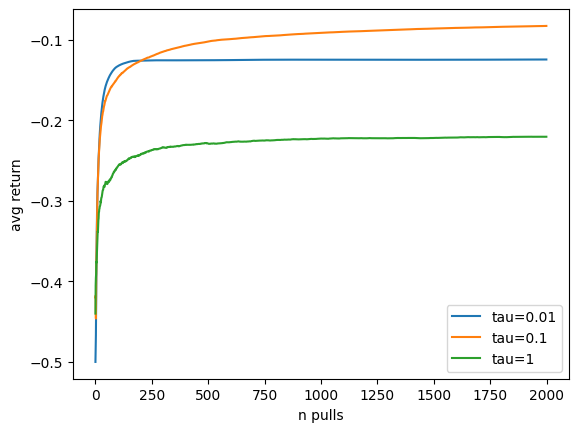

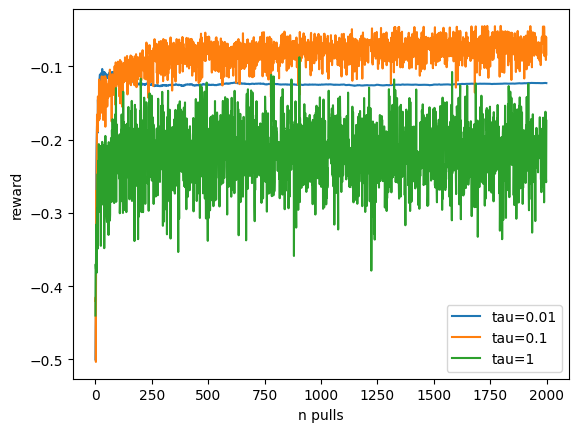

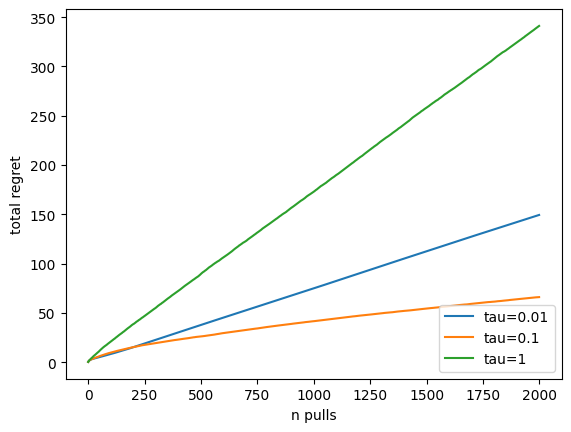

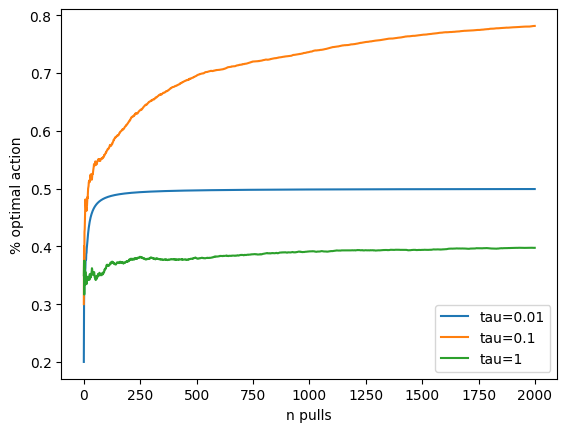

In [18]:
plt.figure(11)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(12)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(13)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(14)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8
for tau in [0.01, 0.1, 1]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)

  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = boltzmann(bandit, tau=tau)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)

  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N

  plt.figure(11)
  plt.plot(avg_ret_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  plt.figure(12)
  plt.plot(rew_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  plt.figure(13)
  plt.plot(tot_reg_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  plt.figure(14)
  plt.plot(opt_act_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        boltzmann_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Q1.d4: Analysis (5 points)

 Explain the role of $\tau$ paramtere on the results.

1. **τ = 0.01 (Low Exploration, High Exploitation):**
   - With τ set to a very low value, the Boltzmann exploration strategy becomes highly deterministic.
   - Action selection is primarily driven by the estimated action values, with very little randomness. The action with the highest estimated value is almost always chosen.
   - This leads to strong exploitation, where the agent focuses almost exclusively on the action it currently believes to have the highest expected reward.
   - It performs as the middle one in our case.

2. **τ = 0.1 (Balanced Exploration and Exploitation):**
   - With τ set to an intermediate value, the Boltzmann strategy achieves a balance between exploration and exploitation.
   - Action selection is influenced by both estimated action values and randomness, with actions having higher estimated values being more likely to be chosen, but there is still some variability.
   - This level of exploration allows the agent to occasionally explore other actions, even if it believes one action is superior. It strikes a balance between refining its estimates and maximizing rewards.
    - It performs as the best one in our case.

3. **τ = 1 (High Exploration, Low Exploitation):**
   - When τ is set to a high value, the Boltzmann strategy encourages extensive exploration.
   - Action selection probabilities are much more evenly distributed, and actions with lower estimated values have a higher chance of being selected.
   - This leads to significant exploration, as the agent is willing to try out different actions, even if it has a good estimate of the optimal action.
   - It performs as the worst one in our case.


### Q1.f: Gradient Bandits Algorithm (15 points)

#### Q1.f1: GB implementation  (5 points)
Follow the lecture notes to implement the Gradient Bandits algorithm with and without the baseline.

In [19]:
def softmax(x):

    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [20]:
def gradient_bandit(
    bandit: Bandit,
    alpha: float,
    use_baseline: bool = True,
    ) -> Tuple[list, list, list]:
  """
  .inputs:
    bandit: A bandit problem, instantiated from the above class.
    alpha: The learning rate.
    use_baseline: Whether or not use avg return as baseline.
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average summation of rewards up to step t, where t goes from 0 to n_pulls. For example: If
    we define `ret_T` = \sum^T_{t=0}{r_t}, `avg_ret_record` = ret_T / (1+T).
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
    opt_action_perc_record: Percentage of optimal arm selected.
  """
  # init h (the logits)
  h = np.array([0]*bandit.n_arm, dtype=float)

  ret = .0
  r_bar_t = 0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []
  opt_action_perc_record = []


  for t in range(bandit.n_pulls):
    # ----------------------------------------------
    p = softmax(h)
    a = np.random.choice(bandit.n_arm, p=p)

    rew = bandit.pull(a)

    if use_baseline:
        r_bar_t = r_bar_t + (rew - r_bar_t) / (t+1)
        for i in range(len(h)):
            if i == a:
                h[a] = h[a] + alpha * (rew - r_bar_t) * p[a] * (1 - p[a])
            else:
                h[i] = h[i] - alpha * (rew - r_bar_t) * p[a] * p[i]
    else:
        for i in range(len(h)):
            if i == a:
                h[a] = h[a] + alpha * rew * p[a] * (1 - p[a])
            else:
                h[i] = h[i] - alpha * rew * p[a] * p[i]

    rew_record.append(rew)
    ret += rew
    avg_ret_record.append(ret / (t+1))

    tot_reg_record.append((t+1) * bandit.q_a_star - ret)

    opt_action_perc = np.sum(bandit.num_dose_selected[bandit.a_star])/np.sum(bandit.num_dose_selected)
    opt_action_perc_record.append(opt_action_perc)
    # ----------------------------------------------

  return rew_record, avg_ret_record, tot_reg_record, opt_action_perc_record

In [21]:
grader.check("q1f1")

q1.f1 results: All test cases passed!

#### Q1.f2: Plotting the results (5 points)

Evaluate the GB algorithm on the same MAB problem as above, for three values of the parameters $\alpha$: $0.05$, $0.1$, and $2$. Use the driver code provided to plot their performances.

**With baseline:**

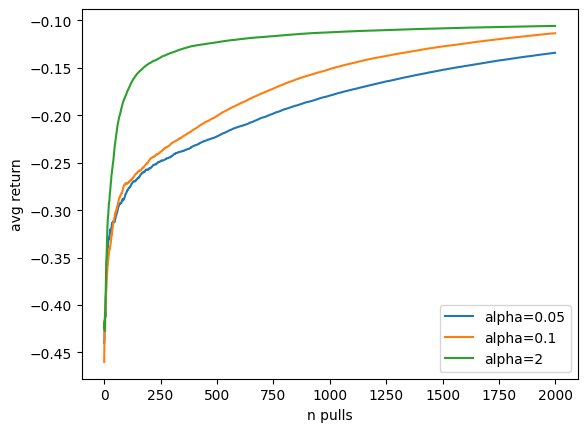

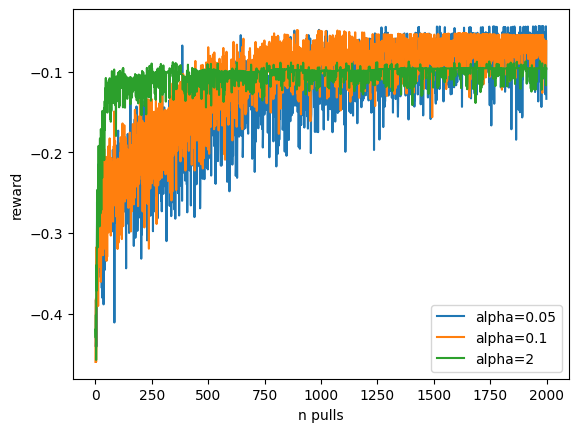

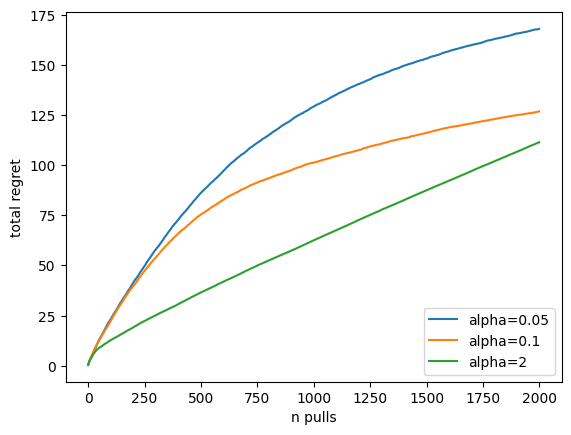

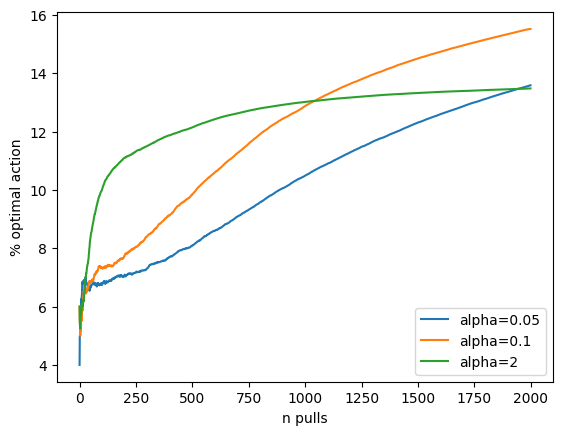

In [22]:
plt.figure(15)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(16)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(17)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(18)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8
for alpha in [0.05, 0.1, 2]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)

  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = gradient_bandit(bandit, alpha=alpha)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)


  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N

  plt.figure(15)
  plt.plot(avg_ret_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(16)
  plt.plot(rew_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(17)
  plt.plot(tot_reg_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(18)
  plt.plot(opt_act_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        gradient_bandit_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

**Without baseline:**

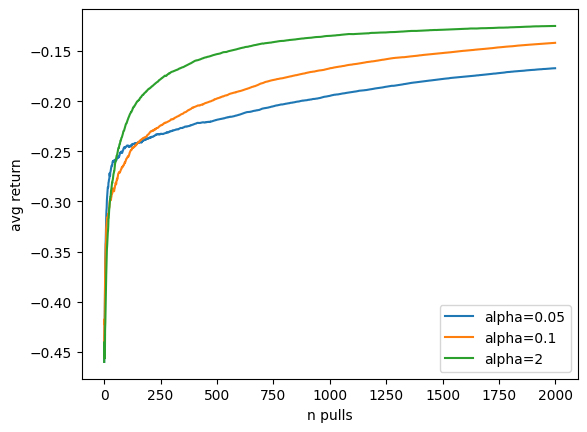

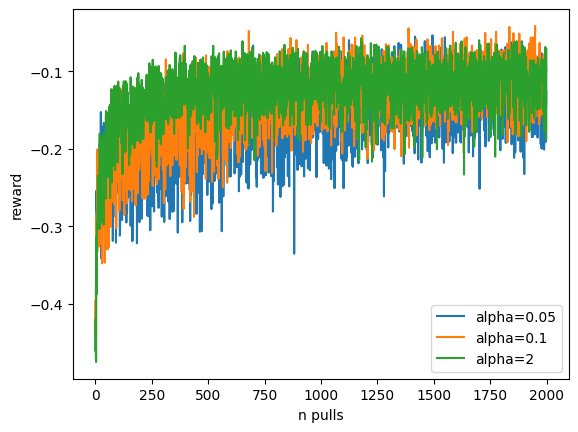

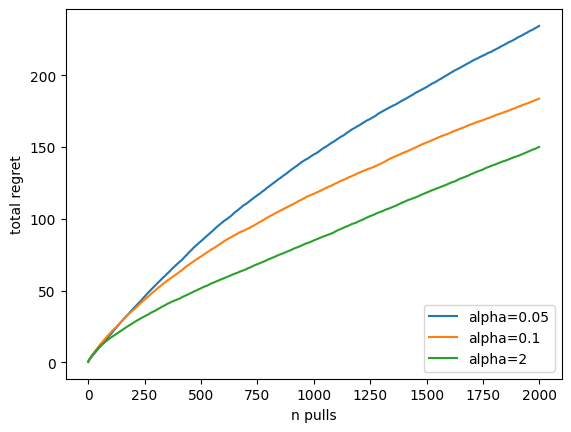

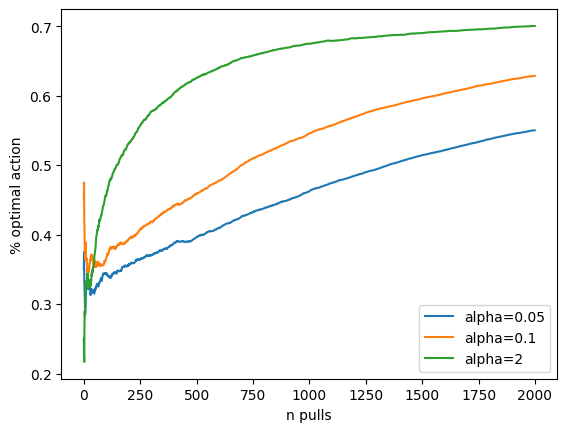

In [23]:
plt.figure(19)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(20)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(21)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(22)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8
for alpha in [0.05, 0.1, 2]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)

  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = gradient_bandit(bandit, alpha=alpha, use_baseline=False)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)


  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N

  plt.figure(19)
  plt.plot(avg_ret_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(20)
  plt.plot(rew_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(21)
  plt.plot(tot_reg_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(22)
  plt.plot(opt_act_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        gradient_bandit_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Q1.f3: Analysis (5 points)

Explain the role of $\alpha$ and the baseline on the results.

1. **$\alpha = 0.05$ (Low Learning Rate):**
   - With a low learning rate, the parameter updates during the learning process are relatively small.
   - Low learning rates are cautious and result in more stable learning, but they can be slow to converge.
   - Pros:
     - Stability: The learning process is less likely to diverge or exhibit significant oscillations.
     - Safe Exploration: Smaller updates ensure that the agent's policy changes gradually, which can be helpful when exploring in complex environments.
   - Cons:
     - Slower Convergence: Learning may take longer to converge to an optimal policy, especially in situations with sparse rewards or complex state spaces.

2. **$\alpha = 0.1$ (Moderate Learning Rate):**
   - A moderate learning rate balances the trade-off between learning speed and stability.
   - It allows for reasonably sized updates, promoting relatively fast convergence while maintaining some degree of stability.
   - Pros:
     - Balanced Trade-off: This learning rate strikes a good balance between convergence speed and stability.
     - Effective Learning: It often results in efficient learning, especially in moderately challenging environments.


3. **$\alpha = 2$ (High Learning Rate):**
   - A high learning rate leads to large parameter updates, which can result in faster learning but at the cost of stability.
   - High learning rates can cause the learning process to become unstable, leading to divergence.
   - Pros:
     - Fast Learning: Learning is accelerated, and the agent can quickly adapt to changes in the environment.
   - Cons:
     - Instability: High learning rates can lead to oscillations, divergence, and difficulty converging to a good policy.



<!-- BEGIN QUESTION -->

### Q1.g: Final comaprison (10 points)

#### Q1.g1: plots (5 points)
Compare the performance of $\epsilon$-greedy, UCB, Boltzmann algorithm, and Gradient Bandit algorithm in a single plot as measured by the average reward and total regret.

Text(0, 0.5, 'total regret')

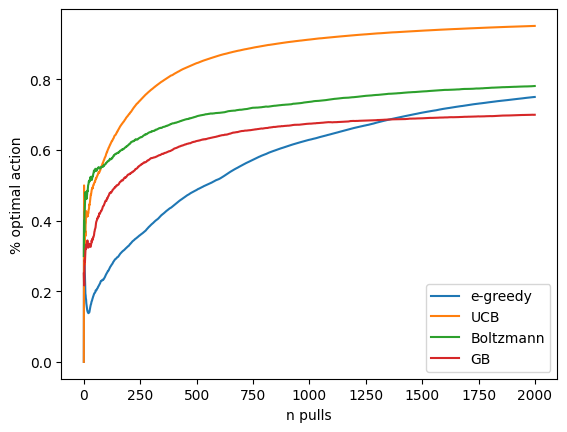

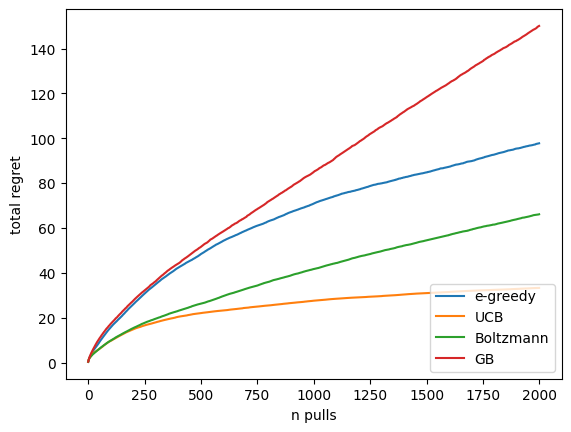

In [24]:
plt.figure(23)
plt.plot(ep_greedy_dict["opt_act"], label="e-greedy")
plt.legend(loc="lower right")
plt.plot(ucb_dict["opt_act"], label="UCB")
plt.legend(loc="lower right")
plt.plot(boltzmann_dict["opt_act"], label="Boltzmann")
plt.legend(loc="lower right")
plt.plot(gradient_bandit_dict["opt_act"], label="GB")
plt.legend(loc="lower right")
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

plt.figure(24)
plt.plot(ep_greedy_dict["regret_list"], label="e-greedy")
plt.legend(loc="lower right")
plt.plot(ucb_dict["regret_list"], label="UCB")
plt.legend(loc="lower right")
plt.plot(boltzmann_dict["regret_list"], label="Boltzmann")
plt.legend(loc="lower right")
plt.plot(gradient_bandit_dict["regret_list"], label="GB")
plt.legend(loc="lower right")
plt.xlabel("n pulls")
plt.ylabel("total regret")

#### Q1.g2: Analysis (5 points)

Compare all the algorithms in terms of their performance.

Comparing the performance of different exploration strategies, such as epsilon-greedy, Upper Confidence Bound (UCB), and Boltzmann, depends on the specific problem, its characteristics, and the goals of the learning agent. Let's compare these exploration strategies based on various factors:

1. **Exploration vs. Exploitation Balance:**
   - **Epsilon-Greedy:** Epsilon-greedy is relatively simple to implement and understand. It strikes a balance between exploration and exploitation but can be somewhat rigid in its approach. It explores randomly with a fixed probability (ε) and exploits the best-known action with probability (1-ε).
   - **UCB:** UCB encourages exploration by assigning exploration bonuses to actions based on their estimated uncertainty. It adapts to the level of uncertainty and can explore more efficiently in unknown regions of the action space.
   - **Boltzmann (Softmax):** Boltzmann exploration offers a continuous spectrum of exploration, controlled by the temperature parameter τ. It can smoothly transition between exploration and exploitation modes, making it adaptable to different levels of uncertainty.

2. **Performance in Uncertain Environments:**
   - **Epsilon-Greedy:** It can struggle in highly uncertain environments because it explores randomly with a fixed probability, which may not adapt well to varying levels of uncertainty.
   - **UCB:** UCB performs well in uncertain environments as it actively explores actions with higher uncertainty, which can lead to quicker identification of the best actions.
   - **Boltzmann (Softmax):** Boltzmann exploration is versatile and can adapt to varying levels of uncertainty. It can explore extensively in highly uncertain environments and shift toward exploitation as it gains confidence in its estimates.

3. **Computational Complexity:**
   - **Epsilon-Greedy:** Epsilon-greedy is computationally efficient because it involves simple random selection with a fixed probability.
   - **UCB:** UCB can be computationally more demanding, as it requires maintaining estimates of action values and calculating exploration bonuses.
   - **Boltzmann (Softmax):** Boltzmann exploration involves calculating exponential probabilities, which can be computationally moderate depending on the number of actions and the value of τ.

4. **Sensitivity to Hyperparameters:**
   - **Epsilon-Greedy:** Epsilon-greedy has a single hyperparameter (ε) to tune, and its performance can be sensitive to the choice of ε.
   - **UCB:** UCB has the exploration parameter "c" to tune, and its performance can depend on the proper choice of this parameter.
   - **Boltzmann (Softmax):** Boltzmann exploration has the temperature parameter τ, which must be carefully tuned for optimal performance.

5. **Applicability:**
   - **Epsilon-Greedy:** Epsilon-greedy is a good starting point for simple problems and when computational resources are limited.
   - **UCB:** UCB is effective for problems with varying levels of uncertainty and where efficient exploration is crucial.
   - **Boltzmann (Softmax):** Boltzmann exploration is suitable for problems that require adaptable and smooth exploration-exploitation trade-offs.

In summary, the choice of exploration strategy depends on the specific problem's characteristics and requirements. Epsilon-greedy is simple but may not be the best choice in highly uncertain environments. UCB is effective in uncertain environments but may be more computationally demanding. Boltzmann exploration provides adaptability and smooth transitions between exploration and exploitation but requires tuning of the temperature parameter. Experimentation and empirical evaluation are often necessary to determine the best exploration strategy for a given RL problem.

In [25]:
plt.close('all')

<!-- END QUESTION -->

